# Social Network Analysis

The Spotify Million Playlist Dataset contains 1,000,000 user-generated playlists from the Spotify platform, created between January 2010 and October 2017. Each playlist includes metadata such as playlist titles and track titles. This large-scale dataset supports research in music recommendation systems, particularly in tasks like automatic playlist continuation.
The full dataset is available [here](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/)

In [1]:
import os
import json
import pandas as pd
import numpy as np
from collections import Counter
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt
import pickle

# use style.mpl
plt.style.use('./style.mpl')

In order to build the network we select a random set of slices and we build a dataframe in the form

| pid       | artist_count |
| --------- | ------------ |
| 596487    | {'Justin Timberlake': 3, 'Pharrell Williams': ... }   |
| 596487    | {'Calvin Harris': 5, '50 Cent': 1, 'Kanye West... }   |
| ...       | ...                                                   |

This way we know how many times a given artist appear in a user's playlist and we can build a co-occurrence network where frequent pairings in playlists get heavier edges.

In [2]:
data_path = os.path.join("data/spotify_million_playlist_dataset/data")

slices = [f for f in os.listdir(data_path)]

np.random.seed(42)
np.random.shuffle(slices)

df = pd.DataFrame()
for s in slices[:10]:
    with open(os.path.join(data_path, s)) as f:
        data = json.load(f)

    playlists = data['playlists']

    rows = []

    for playlist in playlists:
        pid = playlist['pid']
        artist_names = [track['artist_name'] for track in playlist['tracks']]
        artist_count = dict(Counter(artist_names))
        rows.append({'pid': pid, 'artist_count': artist_count})

    dd = pd.DataFrame(rows)
    dd.set_index('pid', inplace=True)

    df = pd.concat([df, dd], axis=0)

df.sample(5)

,artist_count
pid,
243271,"{'James Meyers': 1, 'Adventure Club': 1, 'Feen..."
689698,"{'Willie Nelson': 3, 'Chris LeDoux': 8, 'Tim M..."
822753,"{'Migos': 1, 'Drake': 2, 'Nebu Kiniza': 2, '1w..."
689665,"{'The 1975': 3, 'The Naked And Famous': 1, 'Va..."
400441,"{'High Valley': 1, 'Jessta James': 1, 'Shotgun..."


In [3]:
G = nx.Graph()

# Iterate over all playlist rows
for PID, row in df.iterrows():
    artist_dict = row['artist_count']  # Get the artist dictionary

    # Create nodes for each artist
    artist_array = [(artist, frequency) for artist, frequency in artist_dict.items()]
    for node_name, node_frequency in artist_array:
        if not G.has_node(node_name):
            G.add_node(node_name)

    # Add weighted edges between artists in the same playlist
    artist_deque = deque(artist_array)
    while artist_deque:
        left_artist = artist_deque.popleft()
        left_name, left_freq = left_artist
        for right_name, right_freq in artist_deque:
            if G.has_edge(left_name, right_name):
                G[left_name][right_name]['weight'] += left_freq * right_freq
            else:
                G.add_edge(left_name, right_name, weight=left_freq * right_freq)    

In [4]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
subgraph_nodes = [node for node, _ in top_nodes]
subgraph = G.subgraph(subgraph_nodes)

node_popularity = dict(subgraph.degree(weight='weight'))
max_popularity = max(node_popularity.values()) if node_popularity else 1

node_popularity = dict(subgraph.degree(weight='weight'))
max_popularity = max(node_popularity.values()) if node_popularity else 1

node_sizes = [600 + (node_popularity[n] / max_popularity) * 1200 for n in subgraph.nodes()]

edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
max_weight = max(edge_weights) if edge_weights else 1
normalized_weights = [w / max_weight * 5 for w in edge_weights]

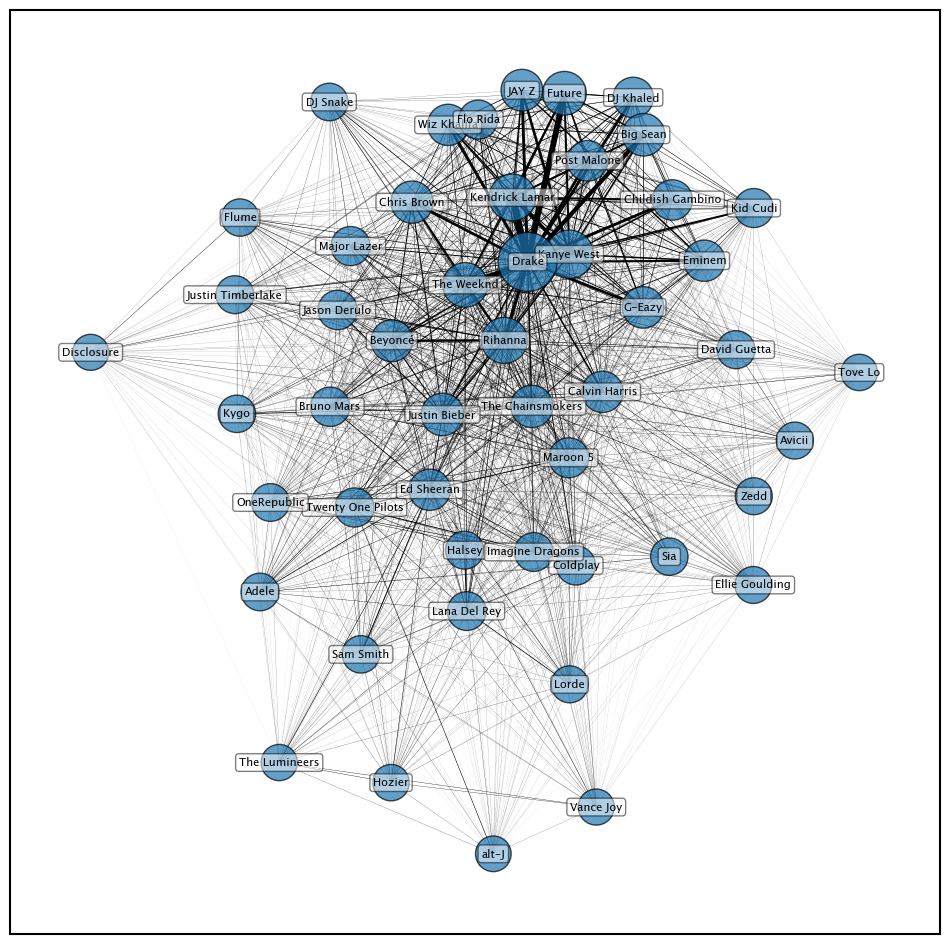

In [5]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(subgraph, k=0.6, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, edgecolors='black', alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, width=normalized_weights, edge_color='black')
nx.draw_networkx_labels(subgraph, pos, font_size=8, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

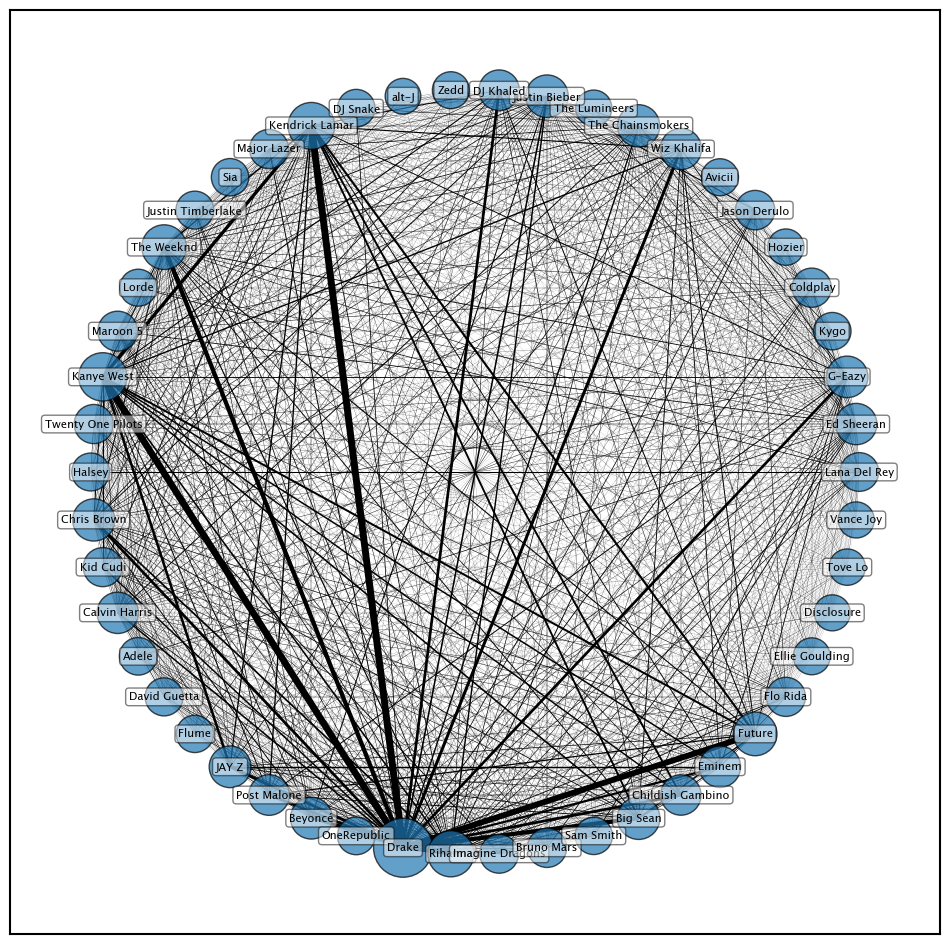

In [6]:
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(subgraph)

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, edgecolors='black', alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, width=normalized_weights, edge_color='black')
nx.draw_networkx_labels(subgraph, pos, font_size=8, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

Dump the graph and the dataset

In [7]:
pickle.dump(G, open('data/graph.pkl', 'wb'))
pd.to_pickle(df, 'data/artist_count.pkl')